In [1]:
import torch
import numpy as np
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import (
    Gemma2ForCausalLM,
    AutoTokenizer,
    HybridCache,
    LlamaForCausalLM,
    LlamaTokenizerFast,
    GPT2LMHeadModel,
    GPT2TokenizerFast,
)


device = "mps"

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

In [2]:
model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model = LlamaForCausalLM.from_pretrained(model_path, attn_implementation="eager").to(
    device
)

tokenizer = LlamaTokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'LlamaTokenizerFast'.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


In [ ]:
model_path = "/Users/aszab/repos/models/gemma-2-2b"
model = Gemma2ForCausalLM.from_pretrained(model_path).to(device)

tokenizer = AutoTokenizer.from_pretrained(model_path)

In [3]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

---

In [73]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

In [4]:
inputs["input_ids"]

tensor([[128000,   9906,     11,    856,   5679,    374,  19369,    323]],
       device='mps:0')

In [60]:
len(past_key_values)

12

In [79]:
past_key_values = [[1, 2, 3, 4, 5], [5, 6, 7, 8, 9]]

In [80]:
reordered_cache = [[] for _ in range(len(past_key_values[0]))]
for kv in past_key_values:
    for i, layer in enumerate(kv):
        reordered_cache[i].append(layer)

In [84]:
reordered_cache

[[1, 5], [2, 6], [3, 7], [4, 8], [5, 9]]

In [5]:
past_key_values[0][0].shape

torch.Size([1, 8, 8, 64])

In [6]:
past_key_values[0][0].shape

torch.Size([1, 8, 8, 64])

In [ ]:
inputs = tokenizer("really ", return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(
        inputs["input_ids"][:, -1:],
        # pad_token_id=model.config.pad_token_id
        past_key_values=past_key_values,
        use_cache=True,
    )

In [8]:
tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])

'2'

---

In [43]:
past_key_values

In [3]:
# import math
# from typing import Optional, Tuple

# import torch
# from torch import nn
# import torch.utils.checkpoint

# import torch.nn.functional as F

# from transformers.models.llama.modeling_llama import (
#     LlamaAttention,
#     rotate_half,
#     apply_rotary_pos_emb,
#     repeat_kv,
# )
# import types

# from transformers.cache_utils import DynamicCache

# __all__ = ["enable_llama_pos_shift_attention"]


# def apply_rotary_pos_emb_single(x, cos, sin, position_ids):
#     # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
#     cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
#     sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
#     cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
#     sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
#     x_embed = (x * cos) + (rotate_half(x) * sin)
#     return x_embed


# def llama_pos_shift_attention_forward(
#     self,
#     hidden_states: torch.Tensor,
#     attention_mask: Optional[torch.Tensor] = None,
#     position_ids: Optional[torch.LongTensor] = None,
#     past_key_value: Optional[Tuple[torch.Tensor]] = None,
#     output_attentions: bool = False,
#     use_cache: bool = False,
#     **kwargs,
# ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
#     bsz, q_len, _ = hidden_states.size()

#     query_states = self.q_proj(hidden_states)
#     key_states = self.k_proj(hidden_states)
#     value_states = self.v_proj(hidden_states)

#     query_states = query_states.view(
#         bsz, q_len, self.num_heads, self.head_dim
#     ).transpose(1, 2)
#     key_states = key_states.view(
#         bsz, q_len, self.num_key_value_heads, self.head_dim
#     ).transpose(1, 2)
#     value_states = value_states.view(
#         bsz, q_len, self.num_key_value_heads, self.head_dim
#     ).transpose(1, 2)

#     kv_seq_len = key_states.shape[-2]
#     print(past_key_value, past_key_value is None)
#     print(len(past_key_value))
#     if past_key_value is not None and len(past_key_value) != 0:
#         kv_seq_len += past_key_value[0].shape[-2]
#     cos, sin = self.rotary_emb(value_states, position_ids=position_ids)
#     ### Shift Pos: query pos is min(cache_size, idx)
#     # query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin, position_ids)
#     query_states = apply_rotary_pos_emb_single(query_states, cos, sin, position_ids)
#     ###

#     if past_key_value is not None and len(past_key_value) != 0:
#         # reuse k, v, self_attention
#         key_states = torch.cat([past_key_value[0], key_states], dim=2)
#         value_states = torch.cat([past_key_value[1], value_states], dim=2)

#     print("ABC")

#     past_key_value = (key_states, value_states) if use_cache else None
#     print(key_states.shape, value_states.shape)
#     print(len(past_key_value))

#     # reordered_cache = [[] for _ in range(len(past_key_value[0]))]
#     # for kv in past_key_value:
#     #     for i, layer in enumerate(kv):
#     #         reordered_cache[i].append(layer)
#     if past_key_value is not None:
#         cache_kwargs = {"sin": sin, "cos": cos, "cache_position": cache_position}
#         key_states, value_states = past_key_value.update(
#             key_states, value_states, self.layer_idx, cache_kwargs
#         )

#     ### Shift Pos: key pos is the pos in cache
#     key_position_ids = torch.arange(kv_seq_len, device=position_ids.device).unsqueeze(0)
#     key_states = apply_rotary_pos_emb_single(key_states, cos, sin, key_position_ids)
#     ###

#     # repeat k/v heads if n_kv_heads < n_heads
#     key_states = repeat_kv(key_states, self.num_key_value_groups)
#     value_states = repeat_kv(value_states, self.num_key_value_groups)

#     attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(
#         self.head_dim
#     )

#     if attn_weights.size() != (bsz, self.num_heads, q_len, kv_seq_len):
#         raise ValueError(
#             f"Attention weights should be of size {(bsz, self.num_heads, q_len, kv_seq_len)}, but is"
#             f" {attn_weights.size()}"
#         )

#     if attention_mask is not None:
#         if attention_mask.size() != (bsz, 1, q_len, kv_seq_len):
#             raise ValueError(
#                 f"Attention mask should be of size {(bsz, 1, q_len, kv_seq_len)}, but is {attention_mask.size()}"
#             )
#         attn_weights = attn_weights + attention_mask

#     # upcast attention to fp32
#     attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(
#         query_states.dtype
#     )
#     attn_output = torch.matmul(attn_weights, value_states)

#     if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
#         raise ValueError(
#             f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
#             f" {attn_output.size()}"
#         )

#     attn_output = attn_output.transpose(1, 2).contiguous()
#     attn_output = attn_output.reshape(bsz, q_len, self.hidden_size)

#     attn_output = self.o_proj(attn_output)

#     if not output_attentions:
#         attn_weights = None

#     return attn_output, attn_weights, past_key_value


# def enable_llama_pos_shift_attention(model):
#     for name, module in reversed(model._modules.items()):
#         if len(list(module.children())) > 0:
#             enable_llama_pos_shift_attention(
#                 module,
#             )

#         if isinstance(module, LlamaAttention):
#             model._modules[name].forward = types.MethodType(
#                 llama_pos_shift_attention_forward, model._modules[name]
#             )

In [23]:
import math
from typing import Optional, Tuple

import torch
from torch import nn
import torch.utils.checkpoint

import torch.nn.functional as F

from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    # rotate_half,
    # apply_rotary_pos_emb,
    repeat_kv,
)
import types

from transformers.cache_utils import DynamicCache, Cache

__all__ = ["enable_llama_pos_shift_attention"]


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def apply_rotary_pos_emb_single(x, cos, sin, unsqueeze_dim=1):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    # print(cos.shape, sin.shape)
    # cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    # sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    # print(cos.shape, sin.shape)
    # cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    # sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    # print(cos.shape, sin.shape)
    # print(x.shape)
    # x_embed = (x * cos) + (rotate_half(x) * sin)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed


def llama_sink_attention_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
    cache_position: Optional[torch.LongTensor] = None,
    position_embeddings: Optional[
        Tuple[torch.Tensor, torch.Tensor]
    ] = None,  # will become mandatory in v4.46
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # use -1 to infer num_heads and num_key_value_heads as they may vary if tensor parallel is used
    query_states = query_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)

    # if past_key_value is not None:
    #     print(len(past_key_value))

    # print("Key states:", key_states.shape[-2])
    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None and len(past_key_value) > self.layer_idx:
        # print("Past key states:", past_key_value[self.layer_idx][0].shape[-2])
        kv_seq_len += past_key_value[self.layer_idx][0].shape[-2]

    q_position_ids = torch.LongTensor([kv_seq_len]).unsqueeze(0)

    if past_key_value is not None:
        cache_kwargs = {"cache_position": cache_position}
        key_states, value_states = past_key_value.update(
            key_states, value_states, self.layer_idx, cache_kwargs
        )

    # print(key_states.shape, value_states.shape)

    if position_embeddings is None:
        logger.warning_once(
            "The attention layers in this model are transitioning from computing the RoPE embeddings internally "
            "through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed "
            "`position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be "
            "removed and `position_embeddings` will be mandatory."
        )
        cos, sin = self.rotary_emb(value_states, q_position_ids)
    else:
        cos, sin = position_embeddings

    # query_states = apply_rotary_pos_emb_single(query_states, cos, sin)

    # key_position_ids = torch.arange(kv_seq_len, device=q_position_ids.device).unsqueeze(
    #     0
    # )
    # key_states = apply_rotary_pos_emb_single(key_states, cos, sin)

    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)
    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(
        self.head_dim
    )

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(
        query_states.dtype
    )
    attn_weights = nn.functional.dropout(
        attn_weights, p=self.attention_dropout, training=self.training
    )
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, -1)

    attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


def enable_llama_pos_shift_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            enable_llama_pos_shift_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                llama_sink_attention_forward, model._modules[name]
            )

In [101]:
import math
from typing import Optional, Tuple

import torch
from torch import nn
import torch.utils.checkpoint

import torch.nn.functional as F

from transformers.models.llama.modeling_llama import (
    LlamaAttention,
    # rotate_half,
    # apply_rotary_pos_emb,
    repeat_kv,
)
import types

from transformers.cache_utils import DynamicCache, Cache

__all__ = ["enable_llama_pos_shift_attention"]


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def apply_rotary_pos_emb_single(x, cos, sin, unsqueeze_dim=1):
    # The first two dimensions of cos and sin are always 1, so we can `squeeze` them.
    # print(cos.shape, sin.shape)
    # cos = cos.squeeze(1).squeeze(0)  # [seq_len, dim]
    # sin = sin.squeeze(1).squeeze(0)  # [seq_len, dim]
    # print(cos.shape, sin.shape)
    # cos = cos[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    # sin = sin[position_ids].unsqueeze(1)  # [bs, 1, seq_len, dim]
    # print(cos.shape, sin.shape)
    # print(x.shape)
    # x_embed = (x * cos) + (rotate_half(x) * sin)
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    x_embed = (x * cos) + (rotate_half(x) * sin)
    return x_embed


def llama_original_attention_forward(
    self,
    hidden_states: torch.Tensor,
    attention_mask: Optional[torch.Tensor] = None,
    position_ids: Optional[torch.LongTensor] = None,
    past_key_value: Optional[Cache] = None,
    output_attentions: bool = False,
    use_cache: bool = False,
    cache_position: Optional[torch.LongTensor] = None,
    position_embeddings: Optional[
        Tuple[torch.Tensor, torch.Tensor]
    ] = None,  # will become mandatory in v4.46
    **kwargs,
) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
    bsz, q_len, _ = hidden_states.size()

    query_states = self.q_proj(hidden_states)
    key_states = self.k_proj(hidden_states)
    value_states = self.v_proj(hidden_states)

    # use -1 to infer num_heads and num_key_value_heads as they may vary if tensor parallel is used
    query_states = query_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    key_states = key_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)
    value_states = value_states.view(bsz, q_len, -1, self.head_dim).transpose(1, 2)

    # print(position_ids)

    kv_seq_len = key_states.shape[-2]
    if past_key_value is not None and len(past_key_value) > self.layer_idx:
        # print("Past key states:", past_key_value[self.layer_idx][0].shape[-2])
        kv_seq_len += past_key_value[self.layer_idx][0].shape[-2]

    # print(kv_seq_len)

    if past_key_value is not None:
        # sin and cos are specific to RoPE models; cache_position needed for the static cache
        cache_kwargs = {"sin": None, "cos": None, "cache_position": cache_position}
        key_states, value_states = past_key_value.update(
            key_states, value_states, self.layer_idx, cache_kwargs
        )

    # if position_embeddings is None:
    #     logger.warning_once(
    #         "The attention layers in this model are transitioning from computing the RoPE embeddings internally "
    #         "through `position_ids` (2D tensor with the indexes of the tokens), to using externally computed "
    #         "`position_embeddings` (Tuple of tensors, containing cos and sin). In v4.46 `position_ids` will be "
    #         "removed and `position_embeddings` will be mandatory."
    #     )
    # cos, sin = self.rotary_emb(
    #     value_states, torch.LongTensor([[kv_seq_len]]).to(value_states.device)
    # )

    # position_ids = torch.arange(kv_seq_len, device=position_ids.device).unsqueeze(0)
    # cos, sin = self.rotary_emb(value_states, position_ids=position_ids)
    # cos, sin = self.rotary_emb(value_states, position_ids=position_ids)

    cos, sin = self.rotary_emb(
        value_states,
        position_ids=torch.arange(kv_seq_len, device=value_states.device).unsqueeze(0),
    )
    # else:
    #     cos, sin = position_embeddings
    # query_states = apply_rotary_pos_emb_single(query_states, cos, sin)

    # key_position_ids = torch.arange(kv_seq_len, device=position_ids.device).unsqueeze(0)
    # cos, sin = self.rotary_emb(value_states, key_position_ids)
    # key_states = apply_rotary_pos_emb_single(key_states, cos, sin)
    _, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)
    # print(q_len)

    cos, sin = self.rotary_emb(
        value_states,
        position_ids=torch.arange(
            end=kv_seq_len,
            start=kv_seq_len - q_len,
            device=value_states.device,
        ).unsqueeze(0),
    )
    # print(
    #     torch.arange(
    #         end=kv_seq_len,
    #         start=kv_seq_len - q_len,
    #         device=value_states.device,
    #     )
    # )

    query_states, _ = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    # print(query_states.shape, key_states.shape)

    key_states = repeat_kv(key_states, self.num_key_value_groups)
    value_states = repeat_kv(value_states, self.num_key_value_groups)
    attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(
        self.head_dim
    )

    if attention_mask is not None:  # no matter the length, we just slice it
        causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
        attn_weights = attn_weights + causal_mask

    # upcast attention to fp32
    attn_weights = nn.functional.softmax(attn_weights, dim=-1, dtype=torch.float32).to(
        query_states.dtype
    )
    attn_weights = nn.functional.dropout(
        attn_weights, p=self.attention_dropout, training=self.training
    )
    attn_output = torch.matmul(attn_weights, value_states)

    if attn_output.size() != (bsz, self.num_heads, q_len, self.head_dim):
        raise ValueError(
            f"`attn_output` should be of size {(bsz, self.num_heads, q_len, self.head_dim)}, but is"
            f" {attn_output.size()}"
        )

    attn_output = attn_output.transpose(1, 2).contiguous()

    attn_output = attn_output.reshape(bsz, q_len, -1)

    attn_output = self.o_proj(attn_output)

    if not output_attentions:
        attn_weights = None

    return attn_output, attn_weights, past_key_value


def enable_llama_pos_shift_attention(model):
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            enable_llama_pos_shift_attention(
                module,
            )

        if isinstance(module, LlamaAttention):
            model._modules[name].forward = types.MethodType(
                llama_original_attention_forward, model._modules[name]
            )

In [102]:
enable_llama_pos_shift_attention(model)

In [103]:
inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)

outputs = model(
    **inputs,
    # pad_token_id=model.config.pad_token_id
    labels=inputs["input_ids"],
)
past_key_values = outputs.past_key_values
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

In [104]:
tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])

' playful'

In [105]:
# inputs = tokenizer("Hello, my dog is cute and", return_tensors="pt").to(device)
pred_token_idx = outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)

outputs = model(
    pred_token_idx,
    # pad_token_id=model.config.pad_token_id
    # labels=inputs["input_ids"],
    labels=None,
    past_key_values=past_key_values,
)
# past_key_values = outputs.past_key_values

In [106]:
tokenizer.decode(outputs.logits[:, -1, :].argmax(dim=-1).unsqueeze(1)[0])

','

---

In [13]:
outputs.loss

NameError: name 'outputs' is not defined

In [ ]:
pred_token_idx

In [81]:
test = load_dataset(
    "wikitext", "wikitext-2-raw-v1", split="test", cache_dir="~/repos/datasets"
)
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Token indices sequence length is longer than the specified maximum sequence length for this model (289077 > 131072). Running this sequence through the model will result in indexing errors


In [7]:
past_key_values[0][0].shape

NameError: name 'past_key_values' is not defined

### Dense Attention, Window Attention, Sink Attention (`broken` - without RoPE positional encoding shift!)

- For dense attention set `kv_cache_size=-1`, `sink_attn_tks=0`.
- For window attention set `kv_cache_size` to desired max cache length value and `sink_attn_tks=0`.
- For sink attention set both `kv_cache_size` and `sink_attn_tks` to desired values.

`chunk_len` specifies the maximum length of an evaluation sequence. E.g. `chunk_len=5` computes over `A B C D E` F G H I J K

`num_passes` specifies the max number of PPL computations over a sequence of length `chunk_len`. 

`shift_len` specifies the number of tokens the main sequence is shifted by to compute perplexity for the next pass.

E.g. `num_passes=3, chunk_len=5, shift_len=2` computes over:
- `A B C D E` F G H I J K
- A B `C D E F G` H I J K
- A B C D `E F G H I` J K


In [8]:
enable_llama_pos_shift_attention(model)

In [24]:
len(past_key_values[0])

2

In [94]:
model_path = "/Users/aszab/repos/models/Llama-3.2-1B"
model = LlamaForCausalLM.from_pretrained(model_path, attn_implementation="eager").to(
    device
)

tokenizer = LlamaTokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'PreTrainedTokenizerFast'. 
The class this function is called from is 'LlamaTokenizerFast'.


In [110]:
print(encodings.input_ids[:, :10])

max_seq_len = encodings.input_ids.size(1)

num_passes = 1
chunk_len = 1200
shift_len = 50

kv_cache_size = -1  # -1 means infinite cache
sink_attn_tks = 0

assert num_passes * chunk_len <= max_seq_len
seq_len = shift_len * num_passes
print(f"chunk_len: {chunk_len}")

global_nlls = []
global_generation_time = []
global_past_key_values_size = []
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")


for begin_idx in range(0, seq_len, shift_len):
    end_idx = min(begin_idx + chunk_len, max_seq_len)
    print(f"{begin_idx=}, {end_idx=}")

    pbar = tqdm(range(begin_idx, end_idx - 1))

    if isinstance(model, Gemma2ForCausalLM):
        past_key_values = HybridCache(
            config=model.config,
            batch_size=1,
            max_cache_len=chunk_len,
            device=model.device,
            dtype=model.dtype,
        )
    else:
        past_key_values = None

    nlls = []
    generation_time = []
    past_key_values_size = []

    for idx in pbar:
        input_ids = encodings.input_ids[:, idx : idx + 1].to(device)
        with torch.no_grad():

            start_time = time.time()
            outputs = model(
                input_ids,
                past_key_values=past_key_values,
                use_cache=True,
            )

            generation_time.append(time.time() - start_time)

            logits = outputs.logits.view(-1, model.config.vocab_size)
            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)
            # if past_key_values is not None:
            #     print(
            #         len(past_key_values),
            #         len(past_key_values[0]),
            #         past_key_values[0][0].shape,
            #     )

            # time.sleep(1)
            past_key_values = outputs.past_key_values

            # cache eviction
            if kv_cache_size != -1 and not isinstance(past_key_values, HybridCache):
                if past_key_values[0][0].shape[2] >= kv_cache_size:
                    past_key_values = [
                        [
                            torch.cat(
                                [
                                    param[:, :, 0:sink_attn_tks, :],
                                    param[:, :, -(kv_cache_size - sink_attn_tks) :, :],
                                ],
                                2,
                            )
                            for param in head
                        ]
                        for head in past_key_values
                    ]

            # memory measurements
            if isinstance(model, Gemma2ForCausalLM):
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in [
                            *past_key_values.key_cache,
                            *past_key_values.value_cache,
                        ]
                    )
                )

            else:
                past_key_values_size.append(
                    sum(
                        sum([p_i.numel() * p_i.element_size() for p_i in p])
                        for p in past_key_values
                    )
                )

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

        nlls.append(neg_log_likelihood)
        pbar.set_description(
            f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
        )
    global_nlls.append(nlls)
    global_generation_time.append(generation_time)
    global_past_key_values_size.append(past_key_values_size)

tensor([[128000,    271,    284,   8563,    426,  11206,    466,    284,  77425,
           8563]])
chunk_len: 1200
begin_idx=0, end_idx=1200


nll: 2.96, ppl: 19.37: 100%|██████████| 1199/1199 [06:00<00:00,  3.32it/s]     


### Sliding window with recomputation

In [ ]:
print(encodings.input_ids[:, :10])

max_seq_len = encodings.input_ids.size(1)

num_passes = 1
chunk_len = 2048
shift_len = 50
kv_cache_size = 512

assert num_passes * chunk_len <= max_seq_len
seq_len = shift_len * num_passes
print(f"chunk_len: {chunk_len}")

global_nlls = []
global_generation_time = []
global_past_key_values_size = []
loss_fn = torch.nn.CrossEntropyLoss(reduction="none")


for begin_idx in range(0, seq_len, shift_len):
    end_idx = min(begin_idx + chunk_len, max_seq_len)
    print(f"{begin_idx=}, {end_idx=}")

    pbar = tqdm(range(begin_idx, end_idx - 1))

    nlls = []
    generation_time = []
    past_key_values_size = []

    for idx in pbar:
        input_ids = encodings.input_ids[:, max(0, idx - kv_cache_size) : idx + 1].to(
            device
        )
        with torch.no_grad():

            start_time = time.time()
            outputs = model(
                input_ids,
            )

            generation_time.append(time.time() - start_time)

            logits = outputs.logits[:, -1, :]

            label = encodings.input_ids[:, idx + 1 : idx + 2].to(logits.device).view(-1)
            neg_log_likelihood = loss_fn(logits, label)

            # clean apple mps cache (for some reason it does not flush automatically)
            if torch.backends.mps.is_available():
                torch.mps.empty_cache()

        nlls.append(neg_log_likelihood)
        pbar.set_description(
            f"nll: {neg_log_likelihood.item():.2f}, ppl: {torch.exp(neg_log_likelihood).item():.2f}"
        )
    global_nlls.append(nlls)
    global_generation_time.append(generation_time)
    global_past_key_values_size.append(past_key_values_size)

In [111]:
nlls = torch.tensor(global_nlls).mean(dim=0)
past_key_values = torch.tensor(global_past_key_values_size, dtype=torch.float64).mean(
    dim=0
)

In [45]:
past_key_values_size[0]

73728

In [46]:
torch.mps.empty_cache()

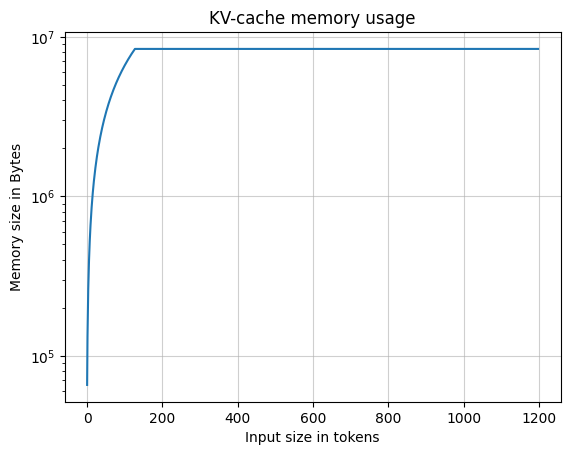

In [91]:
plt.plot(range(len(nlls)), torch.tensor(past_key_values_size))
plt.yscale("log")
plt.title("KV-cache memory usage")
plt.xlabel("Input size in tokens")
plt.ylabel("Memory size in Bytes")
plt.grid(alpha=0.6, zorder=1)

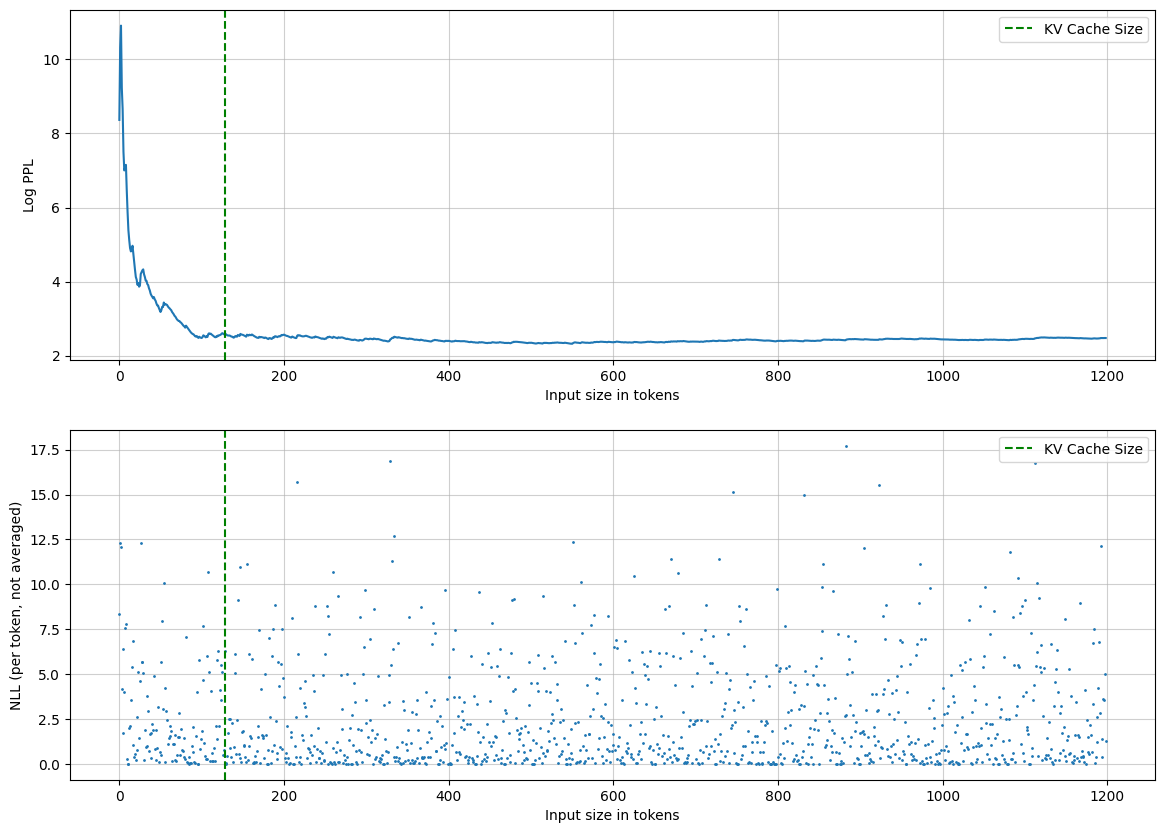

In [109]:
t = nlls

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
# ax[0].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=1,
#     label="Context Length",
# )
ax[0].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=1,
)
# ax[1].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=0.6,
#     label="Context Length",
# )
ax[1].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

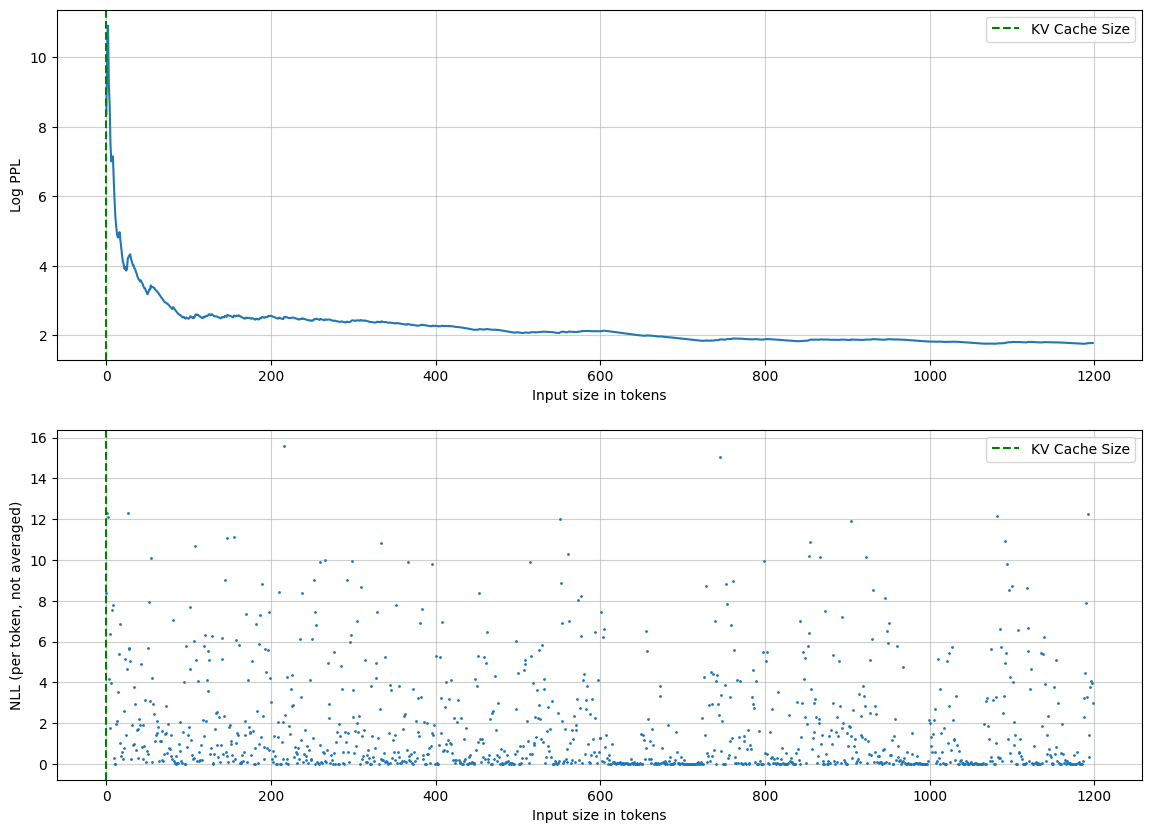

In [112]:
t = nlls

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
# ax[0].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=1,
#     label="Context Length",
# )
ax[0].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=1,
)
# ax[1].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=0.6,
#     label="Context Length",
# )
ax[1].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

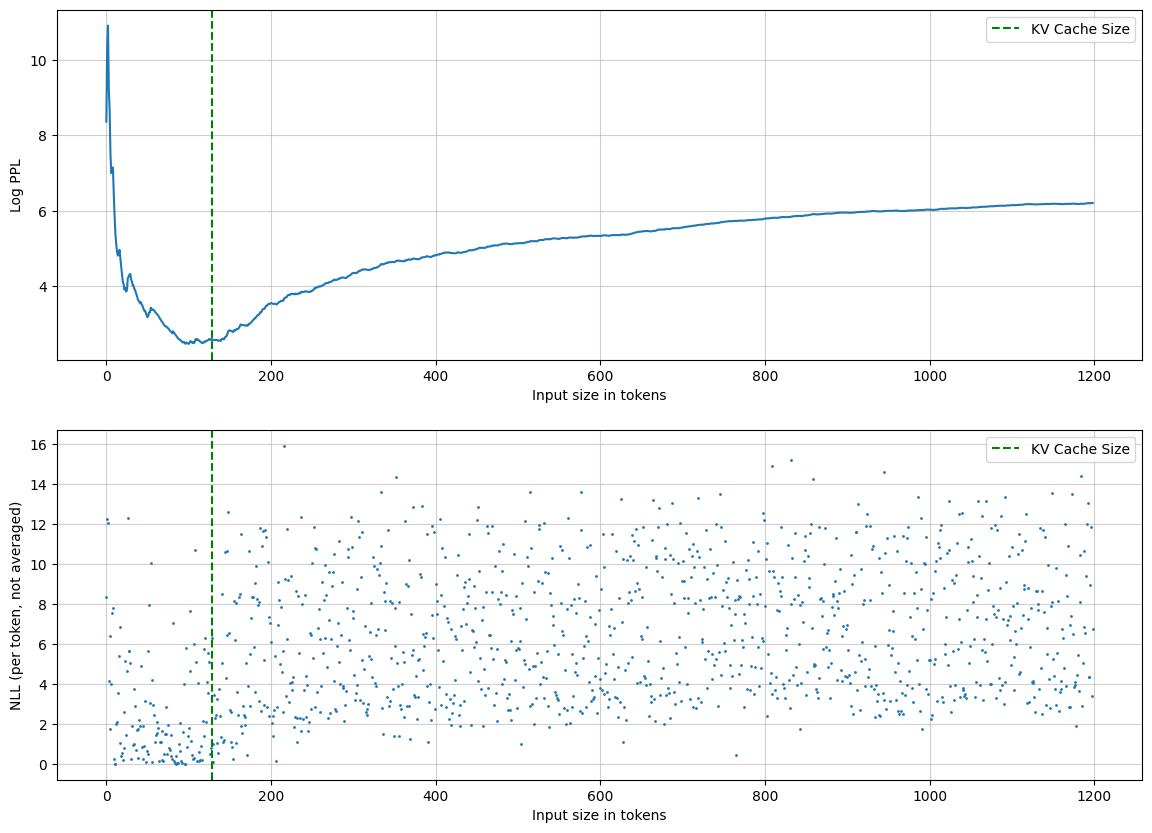

In [100]:
t = nlls

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
ax[0].plot(
    range(len(nlls)),
    [t[: i + 1].mean() for i in range(len(nlls))],
)
# ax[0].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=1,
#     label="Context Length",
# )
ax[0].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[0].set_ylabel("Log PPL")
ax[0].set_xlabel("Input size in tokens")
ax[0].grid(alpha=0.6, zorder=1)
ax[0].legend()

ax[1].plot(
    range(len(nlls)),
    [(t[i]) for i in range(len(nlls))],
    "o",
    # color="red",
    # linewidth=0.1,
    markersize=1,
)
# ax[1].axvline(
#     x=model.config.max_position_embeddings,
#     color="red",
#     linestyle="--",
#     alpha=0.6,
#     label="Context Length",
# )
ax[1].axvline(
    x=kv_cache_size,
    color="green",
    linestyle="--",
    alpha=1,
    label="KV Cache Size",
)
ax[1].set_ylabel("NLL (per token, not averaged)")
ax[1].set_xlabel("Input size in tokens")
ax[1].grid(alpha=0.6, zorder=1)
ax[1].legend()

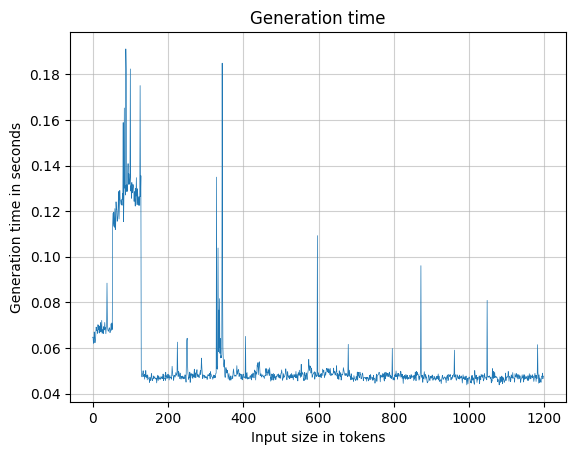

In [93]:
plt.plot(range(len(nlls)), generation_time, linewidth=0.5)
plt.title("Generation time")
plt.xlabel("Input size in tokens")
plt.ylabel("Generation time in seconds")
plt.grid(alpha=0.6, zorder=1)

## Attention visualisations

In [22]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast


model_path = "/Users/aszab/repos/models/gpt2"
model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True).to(device)

tokenizer = GPT2TokenizerFast.from_pretrained(model_path)

if model.config.pad_token_id is None:
    model.config.pad_token_id = model.config.eos_token_id

/Users/aszab/EDU/CAM/modules/L46/project/venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


In [23]:
inputs = tokenizer(
    "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder.",
    return_tensors="pt",
).to(device)

outputs = model(
    **inputs,
)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [24]:
inputs = {"input_ids": encodings["input_ids"][:, :128].to(device)}
outputs = model(**inputs)

In [25]:
inputs["input_ids"]

tensor([[128000,    271,    284,   8563,    426,  11206,    466,    284,  77425,
           8563,    426,  11206,    466,    374,    459,   6498,   4632,   1174,
          12707,    323,  34596,  12360,    662,   1283,   1047,    264,   8810,
            571,     12,     31,  40500,   3560,    389,    279,  12707,   4101,
            578,   8766,    304,    220,   1049,     15,    662,   1115,    574,
           8272,    555,    264,  40500,   3560,    304,    279,   1514,   6385,
           2439,   5439,    555,  22021,  77023,   1174,    902,    574,  10887,
            304,    220,   1049,     16,    520,    279,  16591,   7301,  27315,
            662,   1283,   1047,    264,   8810,   3560,    304,    279,  12707,
           4101,  20819,   3842,   1611,    291,    304,    220,   1049,     17,
            662,    763,    220,   1049,     19,    426,  11206,    466,  27212,
            264,   3560,    439,    330,  29517,    330,    304,    279,   9417,
            330,  71166,    

In [26]:
outputs.attentions[0]

tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [9.3173e-01, 6.8268e-02, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [6.8847e-01, 2.2856e-01, 8.2969e-02,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [2.5448e-02, 4.8725e-03, 7.6201e-03,  ..., 3.5608e-02,
           0.0000e+00, 0.0000e+00],
          [5.9321e-03, 1.3873e-03, 1.5387e-03,  ..., 1.7809e-02,
           2.2251e-02, 0.0000e+00],
          [6.2226e-03, 3.7473e-03, 2.8853e-03,  ..., 4.8501e-02,
           4.8263e-02, 5.5568e-02]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [2.5139e-03, 9.9749e-01, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [5.1548e-03, 2.1317e-03, 9.9271e-01,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [1.0504e-04, 1.7013e-05, 1.5868e-05,  ..., 9.7918

In [27]:
torch.stack(outputs.attentions).cpu().detach().numpy().shape

(12, 1, 12, 128, 128)

In [28]:
def get_attn_map(
    attn: tuple[torch.Tensor], layer_num: int, head_num: int
) -> np.ndarray:
    """
    Retrieves the attention map for a specified layer and head from the model's attention outputs.

    Args:
        attn (tuple[torch.Tensor]): A tuple of attention tensors from the model's output.attentions.
        layer_num (int): The index of the layer from which to retrieve the attention map.
                         If -1, the attention maps across all layers are averaged.
        head_num (int): The index of the head from which to retrieve the attention map.
                        If -1, the attention maps across all heads are averaged.

    Returns:
        np.ndarray: The attention map for the specified layer and head.
    """
    attn = torch.stack(attn).cpu().detach().numpy()
    if layer_num == -1:
        attn = attn.mean(axis=0, keepdims=True)
        layer_num = 0

    if head_num == -1:
        attn = attn.mean(axis=2, keepdims=True)
        head_num = 0

    attn_map = attn[layer_num, 0, head_num, :, :]

    return attn_map

Text(0, 0.5, 'Propotion of attention given to the first token')

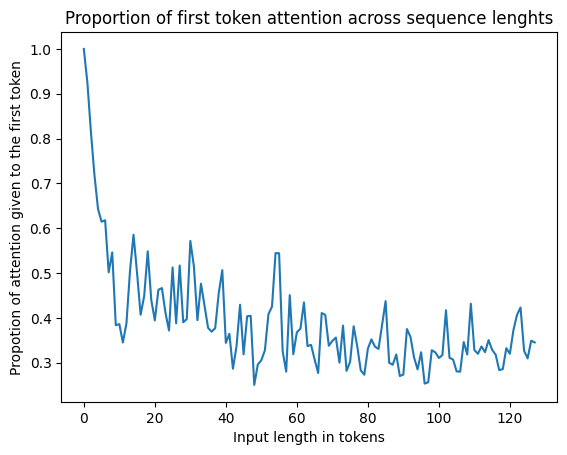

In [29]:
attn_map = get_attn_map(outputs.attentions, -1, -1)
plt.plot(range(attn_map.shape[1]), attn_map[:, 0])
plt.title("Proportion of first token attention across sequence lenghts")
plt.xlabel("Input length in tokens")
plt.ylabel("Propotion of attention given to the first token")

In [30]:
def show_attn(
    attn_map: np.ndarray, token_labels: list[str], log_scale: bool = False
) -> None:
    """
    Visualizes an attention map with token labels.

    Parameters:
        attn_map (np.ndarray): The attention map to visualize. It is expected to be a 2D array.
        token_labels (list[str]): A list of token labels corresponding to the attention map.
        log_scale (bool, optional): If True, applies a logarithmic scale to the attention map values. Defaults to False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    _, ax = plt.subplots(figsize=(8, 8))

    # mask for plotting the bad color for padding tokens (upper triangular part)
    attn_map = np.ma.masked_where(attn_map == 0, attn_map)

    cmap = plt.cm.coolwarm
    cmap.set_bad(color="grey")
    ax.matshow(fn(attn_map), cmap=cmap)

    ax.xaxis.set_label_position("bottom")  # Move x-axis label to the bottom
    ax.xaxis.tick_bottom()  # Ensure ticks are on the bottom
    _ = ax.set_xticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
        rotation=90,
    )
    _ = ax.set_yticks(
        range(len(inputs["input_ids"][0])),
        token_labels,
        fontsize=9,
    )
    ax.set_ylabel("Query token", fontsize=12)
    ax.set_xlabel("Key token", fontsize=12)

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_24190/1193795847.py:24: RuntimeWarning: divide by zero encountered in log
  ax.matshow(fn(attn_map), cmap=cmap)


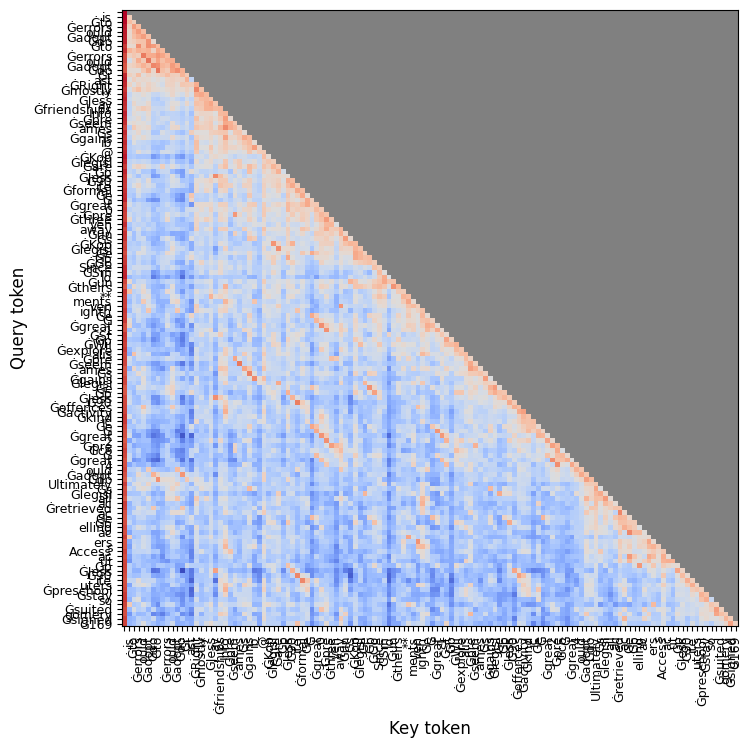

In [31]:
show_attn(
    get_attn_map(outputs.attentions, 7, -1),
    tokenizer.convert_ids_to_tokens(inputs["input_ids"].cpu().detach().numpy()[0]),
    True,
)

In [32]:
def show_attn_layers(attn_map_lst: list[np.ndarray], log_scale: bool = False) -> None:
    """
    Visualizes attention maps for each layer in a grid layout.

    Parameters:
        attn_map_lst (list[np.ndarray]): A list of attention maps, where each attention map is a 2D numpy array.
        log_scale (bool): If True, applies a logarithmic scale to the attention maps for visualization. Default is False.

    Returns:
        None
    """
    fn = np.log if log_scale else lambda x: x

    n_cols = 4
    n_rows = len(attn_map_lst) // n_cols
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(14, 10))

    for i, attn_map in enumerate(attn_map_lst):
        # mask for plotting the bad color for padding tokens (upper triangular part)
        attn_map = np.ma.masked_where(attn_map == 0, attn_map)

        cmap = plt.cm.coolwarm
        cmap.set_bad(color="grey")
        axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)

        axs[i // n_cols][i % n_cols].xaxis.set_label_position(
            "bottom"
        )  # Move x-axis label to the bottom
        axs[i // n_cols][
            i % n_cols
        ].xaxis.tick_bottom()  # Ensure ticks are on the bottom

        axs[i // n_cols][i % n_cols].set_title(f"Layer {i}")
        axs[i // n_cols][i % n_cols].set_ylabel("Query token", fontsize=10)
        axs[i // n_cols][i % n_cols].set_xlabel("Key token", fontsize=10)
        fig.tight_layout()

/var/folders/zy/tf5h417916z3zcml60nrcxvc0000gn/T/ipykernel_24190/2761506107.py:24: RuntimeWarning: divide by zero encountered in log
  axs[i // n_cols][i % n_cols].matshow(fn(attn_map), cmap=cmap)


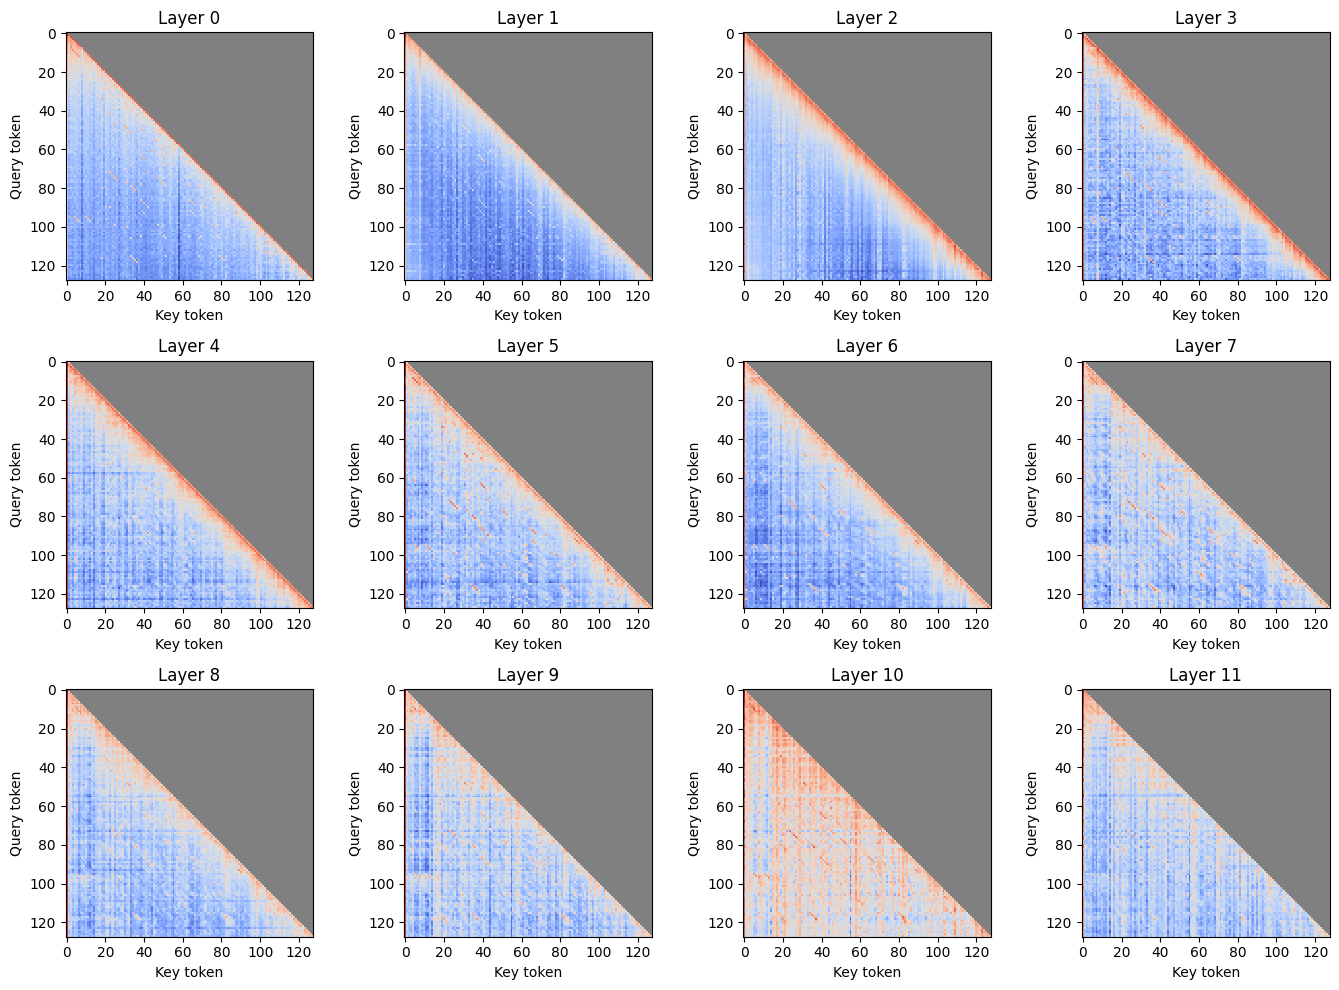

In [33]:
show_attn_layers(
    [get_attn_map(outputs.attentions, i, -1) for i in range(12)], log_scale=True
)